In [1]:
import pandas as pd
import cv2 as cv
import numpy as np
from scipy.stats import skew
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.preprocessing import MinMaxScaler


In [2]:
train_df = pd.read_csv("./dataset/splits/train.csv")
train_df.head()
test_df = pd.read_csv("./dataset/splits/test.csv")
test_df.head()

,Unnamed: 0,clip_name,clip_path,label,encoded_label
0,0,v_Diving_g15_c01.avi,./dataset/Diving/v_Diving_g15_c01.avi,Diving,0
1,1,v_Diving_g17_c01.avi,./dataset/Diving/v_Diving_g17_c01.avi,Diving,0
2,2,v_Diving_g18_c04.avi,./dataset/Diving/v_Diving_g18_c04.avi,Diving,0
3,3,v_Diving_g02_c07.avi,./dataset/Diving/v_Diving_g02_c07.avi,Diving,0
4,4,v_Diving_g24_c05.avi,./dataset/Diving/v_Diving_g24_c05.avi,Diving,0


In [3]:
def manual_normalize(frame):
    mean, std = cv.meanStdDev(frame)
    mean = mean.flatten()
    std = std.flatten()
    return (frame - mean) / std

def open_cv_normalize(frame):
    return cv.normalize(frame, None, alpha=0, beta=1.0, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)

def open_cv_normalization_255(frame):
    return cv.normalize(frame, None, alpha=0, beta=255,
                               norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)


In [4]:
def color_segmentation(frame):
    rgb_frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    hsv_frame = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
    resized_rgb = cv.resize(rgb_frame, (224, 224), interpolation=cv.INTER_CUBIC)
    resized_hsv = cv.resize(hsv_frame, (224, 224), interpolation=cv.INTER_CUBIC)

    hist_features = {}
    for i, col in enumerate(['red', 'green', 'blue']):
        hist = cv.calcHist(resized_rgb, [i], None, [256], [0, 256])
        hist_features[col] = hist.flatten()

    moments = []
    for i in range(3):
        channel = resized_hsv[:, :, i]
        mean = np.mean(channel)
        std = np.std(channel)
        skewness = skew(channel.flatten())
        if np.isnan(skewness):
            skewness = 0
        moments.append([mean, std, skewness])

    avg_color = np.mean(resized_rgb, axis=(0, 1))
    return hist_features, moments, avg_color


In [5]:
def add_color_feature_pipeline(index, file_path) -> dict:
    file = cv.VideoCapture(file_path)
    avg_moments = [0, 0, 0, 0, 0, 0, 0, 0, 0]
    avg_colors = [0, 0, 0]
    while file.isOpened():
        if not file:
            print("Error opening video stream or file")
        ret, frame = file.read()

        if ret:
            hist_features, moments, avg_color = color_segmentation(frame)
            avg_moments[0] += moments[0][0]
            avg_moments[1] += moments[0][1]
            avg_moments[2] += moments[0][2]
            avg_moments[3] += moments[1][0]
            avg_moments[4] += moments[1][1]
            avg_moments[5] += moments[1][2]
            avg_moments[6] += moments[2][0]
            avg_moments[7] += moments[2][1]
            avg_moments[8] += moments[2][2]
            avg_colors[0] += avg_color[0]
            avg_colors[1] += avg_color[1]
            avg_colors[2] += avg_color[2]
        else:
            break
    total_frames = file.get(cv.CAP_PROP_FRAME_COUNT)
    avg_moments[0] /= total_frames
    avg_moments[1] /= total_frames
    avg_moments[2] /= total_frames
    avg_moments[3] /= total_frames
    avg_moments[4] /= total_frames
    avg_moments[5] /= total_frames
    avg_moments[6] /= total_frames
    avg_moments[7] /= total_frames
    avg_moments[8] /= total_frames
    avg_colors[0] /= total_frames
    avg_colors[1] /= total_frames
    avg_colors[2] /= total_frames
    file.release()
    return {'index': index,
        'moments_mean_h': avg_moments[0], 'moments_std_h': avg_moments[1], 'moments_skew_h': avg_moments[2],
        'moments_mean_s': avg_moments[3], 'moments_std_s': avg_moments[4], 'moments_skew_s': avg_moments[5],
        'moments_mean_v': avg_moments[6], 'moments_std_v': avg_moments[7], 'moments_skew_v': avg_moments[8],
        'avg_color_r': avg_colors[0], 'avg_color_g': avg_colors[1], 'avg_color_b': avg_colors[2]}


In [6]:
COLOR_FEATURE_COLUMNS = [
    "moments_mean_h", "moments_std_h", "moments_skew_h",
    "moments_mean_s", "moments_std_s", "moments_skew_s",
    "moments_mean_v", "moments_std_v", "moments_skew_v",
    "avg_color_r", "avg_color_g", "avg_color_b",
]


In [7]:

scaler = MinMaxScaler()


def process_df(df, is_test=False):
    features = []
    for index, row in df.iterrows():
        features.append(add_color_feature_pipeline(index, row.clip_path))

    color_df = pd.DataFrame(
        columns=['index', 'moments_mean_h', 'moments_std_h', 'moments_skew_h', 'moments_mean_s', 'moments_std_s',
                 'moments_skew_s', 'moments_mean_v', 'moments_std_v', 'moments_skew_v', 'avg_color_r', 'avg_color_g',
                 'avg_color_b'],
        data=features)

    for f in COLOR_FEATURE_COLUMNS:
        color_df[f] = color_df[f].astype(float)
        if is_test:
            color_df[COLOR_FEATURE_COLUMNS] = scaler.transform(color_df[COLOR_FEATURE_COLUMNS])
        else:
            color_df[COLOR_FEATURE_COLUMNS] = scaler.fit_transform(color_df[COLOR_FEATURE_COLUMNS])
    return color_df


In [8]:
svm_model = SVC(kernel='rbf', C=1.0, random_state=42, probability=True)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)


def train_pipeline():
    train_color_df = process_df(train_df)
    merged_df = pd.merge(train_df, train_color_df, left_index=True, right_index=True, how='inner')
    merged_df = merged_df.drop(columns=['clip_path', 'Unnamed: 0', 'clip_name', 'index', 'label'])
    output = merged_df['encoded_label']
    merged_df = merged_df.drop(columns=['encoded_label'])
    svm_model.fit(merged_df, output)
    rf_model.fit(merged_df, output)


train_pipeline()


/tmp/ipykernel_135813/1771590084.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = skew(channel.flatten())


SVM classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00         9
           2       0.33      1.00      0.50         9

    accuracy                           0.33        27
   macro avg       0.11      0.33      0.17        27
weighted avg       0.11      0.33      0.17        27

RF classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00         9
           2       0.33      1.00      0.50         9

    accuracy                           0.33        27
   macro avg       0.11      0.33      0.17        27
weighted avg       0.11      0.33      0.17        27



/home/yogendra/workspace/python/university/Video-Analytics-Assignment1/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/yogendra/workspace/python/university/Video-Analytics-Assignment1/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/yogendra/workspace/python/university/Video-Analytics-Assignment1/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels

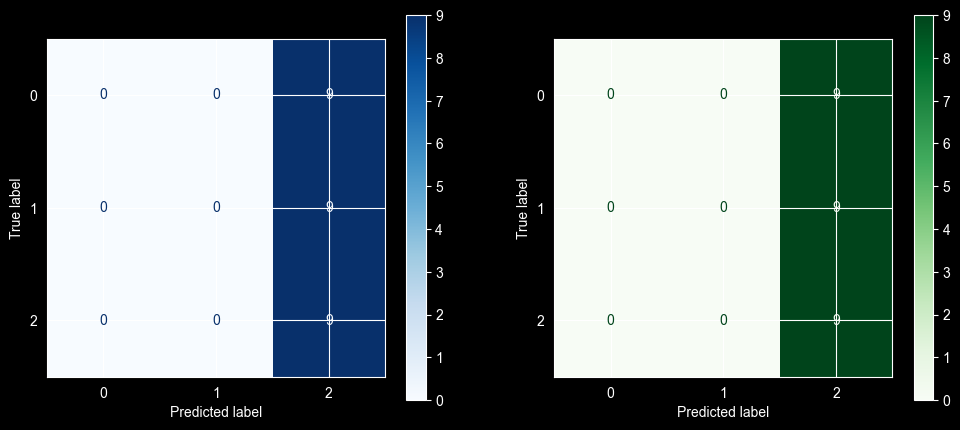

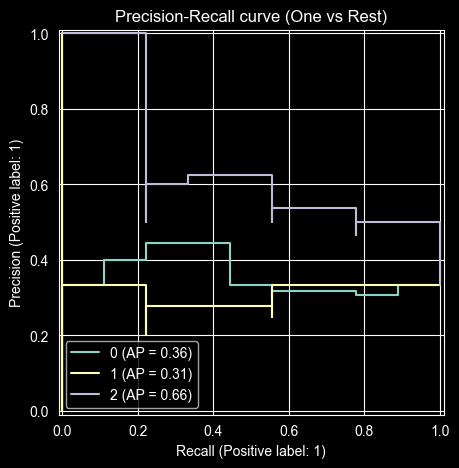

In [9]:
def test_pipeline():
    test_color_df = process_df(test_df, is_test=True)
    merged_df = pd.merge(test_df, test_color_df, left_index=True, right_index=True, how='inner')
    expected_output = test_df['encoded_label']
    merged_df = merged_df.drop(columns=['clip_path', 'Unnamed: 0', 'clip_name', 'index', 'label', 'encoded_label'])
    svm_output = svm_model.predict(merged_df)
    rf_output = rf_model.predict(merged_df)
    print('SVM classification report:')
    print(classification_report(expected_output, svm_output))
    print('RF classification report:')
    print(classification_report(expected_output, rf_output))

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ConfusionMatrixDisplay.from_predictions(expected_output, svm_output, ax=ax[0], cmap='Blues')
    ConfusionMatrixDisplay.from_predictions(expected_output, svm_output, ax=ax[1], cmap='Greens')
    plt.show()

    rf_prob = rf_model.predict_proba(merged_df)
    fig, ax = plt.subplots(figsize=(12, 5))
    for i, class_label in enumerate(rf_model.classes_):
        PrecisionRecallDisplay.from_predictions(expected_output == class_label, rf_prob[:, i], name=class_label, ax=ax)
    ax.set_title('Precision-Recall curve (One vs Rest)')
    plt.show()


test_pipeline()
